# 10kGNAD German News Article Topic Classification Dataset

Obtained from https://tblock.github.io/10kGNAD/ via [github](https://github.com/tblock/10kGNAD) (uses train/test split from git repo)

Original dataset:
```
@inproceedings{schabus2017one,
  title={One million posts: A data set of german online discussions},
  author={Schabus, Dietmar and Skowron, Marcin and Trapp, Martin},
  booktitle={Proceedings of the 40th International ACM SIGIR Conference on Research and Development in Information Retrieval},
  pages={1241--1244},
  year={2017}
}
```

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import hashlib

TRAIN_DATASET_LOCATION = "../datasets/10kgnad/train.csv"
TEST_DATASET_LOCATION = "../datasets/10kgnad/test.csv"

### Validity check

In [2]:
VERIFY_CHECKSUM = True

In [3]:
assert os.path.exists(TRAIN_DATASET_LOCATION)
assert os.path.exists(TEST_DATASET_LOCATION)

def verify_checksum(file, checksum):
    with open(file, "rb") as f:
        file_hash = hashlib.md5()
        while chunk := f.read(8192):
            file_hash.update(chunk)
    assert checksum == file_hash.hexdigest()
    print("Checksum matches")
    
if VERIFY_CHECKSUM:
    verify_checksum(TRAIN_DATASET_LOCATION, '70ce5b37c5a0df4c07148bea7af2397d')
    verify_checksum(TEST_DATASET_LOCATION, '5f092a18f238b06af3c9de96f78eca8b')

Checksum matches
Checksum matches


### Read data

In [4]:
pd.read_csv(TRAIN_DATASET_LOCATION, header=None, sep=";", quotechar="'", nrows=10)

,0,1
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...
5,Wirtschaft,Der Welser Stempelhersteller verbreitert sich ...
6,Sport,Traditionsklub setzt sich gegen den FC Utrecht...
7,Etat,Finanzausschuss tagte Montag: Konfliktthemen S...
8,International,Militär setzt Offensive an Grenze zu Afghanist...
9,Sport,Abschiedstournee für Guardiola beginnt beim HS...


In [5]:
df_train = pd.read_csv(TRAIN_DATASET_LOCATION, header=None, sep=";", quotechar="'")
df_train.columns = ['target', 'text']
df_train.shape

(9245, 2)

In [6]:
df_train.head()

,target,text
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g..."
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo..."
4,Inland,Estland sieht den künftigen österreichischen P...


Text(0.5, 0, 'Count')

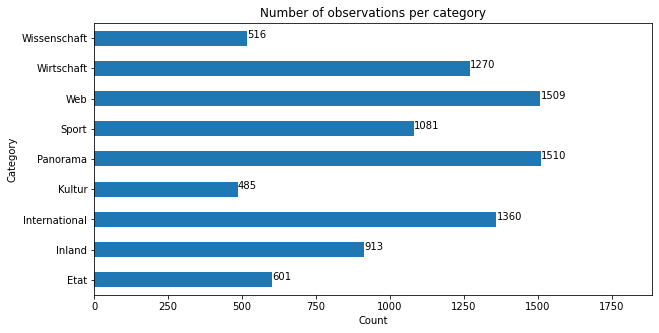

In [7]:
vc = df_train.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [8]:
PREPROCESSED_FILE = '../datasets/preprocessed/10kgnad_train.csv'
df_train.to_csv(PREPROCESSED_FILE, index=False)

### Detect Non-German texts

In [9]:
import fasttext
import numpy as np
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

LANGUAGE_DETECTION_MODEL = "../fasttext/language_identification/lid.176.bin" #https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(LANGUAGE_DETECTION_MODEL)

In [10]:
def get_language(paragraph, k=None, return_all=False, min_certainty=0.25):
    if pd.isna(paragraph):
        return np.nan
    sentences = [line for line in paragraph.split("\n") if line != '']
    if len(sentences) < 1:
        return np.nan
    class_labels, certainties = model.predict(sentences, k)
    # sum certainties per class label and then divide by length -> avg certainty
    class_lookup, indexed_lang = np.unique(np.hstack(class_labels), return_inverse=True)
    summed_certainties = np.bincount(indexed_lang, weights=np.hstack(certainties))/len(sentences)
    if return_all:
        return dict(zip(class_lookup, summed_certainties))
    
    # get most likely lang
    lang_id = np.argmax(summed_certainties)
    if summed_certainties[lang_id] < min_certainty:
        return np.nan
    return class_lookup[lang_id]        

In [11]:
df_train['lang'] = df_train.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/9245 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

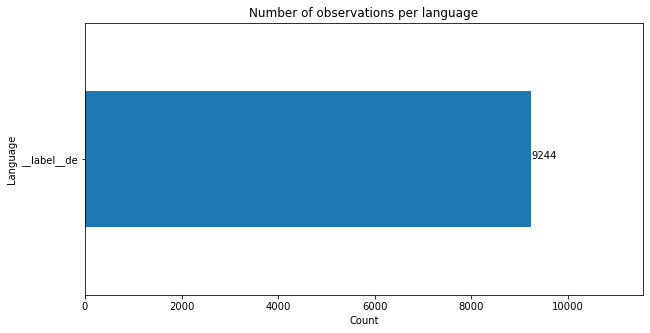

In [12]:
vc = df_train.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [13]:
vc.nlargest(5)

__label__de    9244
Name: lang, dtype: int64

In [14]:
f"{vc['__label__de']/df_train.shape[0]*100:.4f}% of samples are german" 

'99.9892% of samples are german'

### Test Set analysis

In [15]:
df_test = pd.read_csv(TEST_DATASET_LOCATION, header=None, sep=";", quotechar="'")
df_test.columns = ['target', 'text']
df_test.shape

(1028, 2)

In [16]:
df_test.head()

,target,text
0,Wirtschaft,"Die Gewerkschaft GPA-djp lanciert den ""All-in-..."
1,Sport,Franzosen verteidigen 2:1-Führung – Kritische ...
2,Web,Neues Video von Designern macht im Netz die Ru...
3,Sport,23-jähriger Brasilianer muss vier Spiele pausi...
4,International,Aufständische verwendeten Chemikalie bei Gefec...


Text(0.5, 0, 'Count')

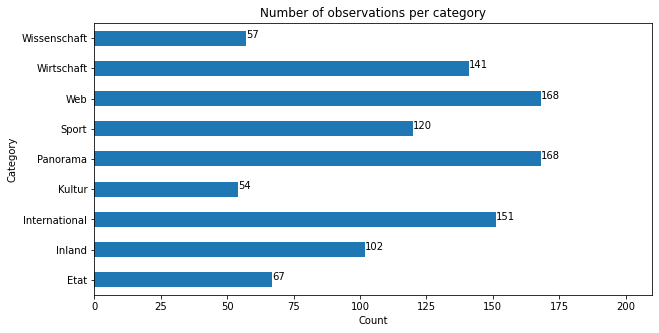

In [17]:
vc = df_test.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [18]:
PREPROCESSED_FILE = '../datasets/preprocessed/10kgnad_test.csv'
df_test.to_csv(PREPROCESSED_FILE, index=False)

In [19]:
df_test['lang'] = df_test.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/1028 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

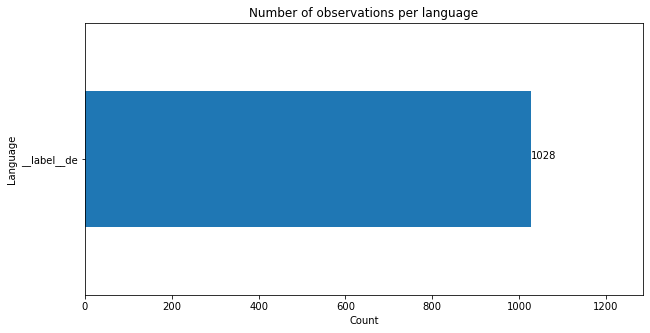

In [20]:
vc = df_test.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [21]:
vc.nlargest(5)

__label__de    1028
Name: lang, dtype: int64

In [22]:
f"{vc['__label__de']/df_test.shape[0]*100:.4f}% of samples are german" 

'100.0000% of samples are german'